# Notes

Modules are from: https://github.com/fhvilshoj/TorchLRP.git

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow
import cv2

from PIL import Image

import lrp

import torch
import torch.nn as nn
from torch import topk
import torchvision
from torchvision import models, transforms

# Define Transform

In [3]:
transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    ])

# Load model

In [4]:
# Load VGG-16 model
vgg = torchvision.models.vgg16(pretrained=True)
vgg.eval()

# Convert VGG model to LRP model
lrp_vgg = lrp.convert_vgg(vgg)

C:\Users\edvin\anaconda3\envs\deepimg\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\edvin\anaconda3\envs\deepimg\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Load labels

In [5]:
def load_synset_classes(file_path):
    # load the synset text file for labels
    all_classes = []
    with open(file_path, 'r') as f:
        for line in f.readlines():
            label = line.strip().split(':', 1)[1].strip(" '").split(',')[0]
            label = label.strip("'")  # Remove any remaining single quotes
            all_classes.append(label)
    return all_classes

# get all the classes in a list
all_classes = load_synset_classes('labels.txt')

# Load image

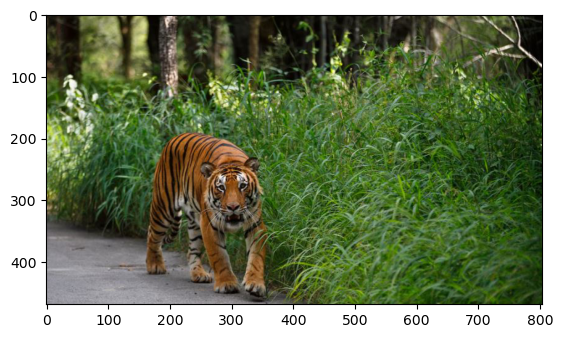

In [6]:
input_file = "tiger.jpg"

image = cv2.imread(input_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape

imshow(image)

# Variations

### Rotate 90

In [7]:
rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

### Rotate 90

In [8]:
rotated_image2 = cv2.rotate(rotated_image, cv2.ROTATE_90_CLOCKWISE)

### Rotate 90

In [9]:
rotated_image3 = cv2.rotate(rotated_image2, cv2.ROTATE_90_CLOCKWISE)

### Show results

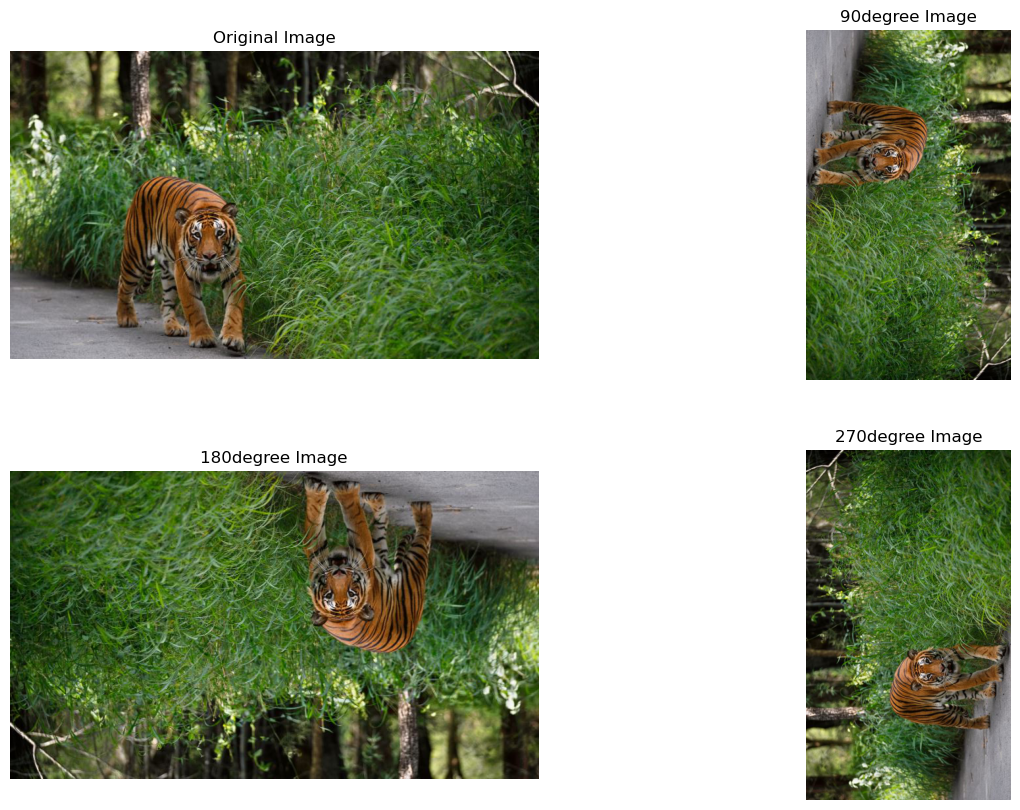

In [10]:
# Display the images in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Display the original image
axs[0,0].imshow(image)
axs[0,0].set_title('Original Image')
axs[0,0].axis('off')

# Display the flipped and noisy image
axs[0,1].imshow(rotated_image)
axs[0,1].set_title('90degree Image')
axs[0,1].axis('off')

# Display the noisy image
axs[1,0].imshow(rotated_image2)
axs[1,0].set_title('180degree Image')
axs[1,0].axis('off')

# Display the enhanced image
axs[1,1].imshow(rotated_image3)
axs[1,1].set_title('270degree Image')
axs[1,1].axis('off')

# Show the grid of images
plt.savefig("LRP_variations.jpg")
plt.show()

# LRP


In [11]:
# Define softmax
softmax = nn.Softmax(dim=1)

In [12]:
def get_LRP(image,transforms):
    # Apply the transforms to the image_copy tensor
    image_t = transforms(image).unsqueeze(0).requires_grad_(True)

    # Forward pass
    y_hat = lrp_vgg.forward(image_t, explain=True, rule="alpha1beta0")

    # probabilities and scores for top k predictions
    probs = softmax(y_hat)
    scores, pred_idx = torch.topk(probs, 1)

    # reformat
    scores = scores.detach().numpy()[0]
    pred_idx = pred_idx.detach().numpy()[0]

    # get label
    pred_label = all_classes[pred_idx[0]]

    # select which node to backpropogate from?
    y_hat = y_hat[torch.arange(image_t.shape[0]), pred_idx[0]]

    # Backward pass (do explanation)
    y_hat.backward()
    lrp = image_t.grad
    
    return lrp,pred_label,scores[0]

### Original

In [15]:
lrp1,pred1,score1 = get_LRP(image,transforms)

### Rotated

In [16]:
lrp2,pred2,score2 = get_LRP(rotated_image,transforms)

### Rotated

In [17]:
lrp3,pred3,score3 = get_LRP(rotated_image2,transforms)

### Rotated

In [18]:
lrp4,pred4,score4 = get_LRP(rotated_image3,transforms)

# Preprocess

In [20]:
def preprocess(lrp,width,height):
    # Plot the processed explanation
    processed_lrp = lrp[0].detach().cpu().numpy().transpose(1, 2, 0)

    flat_image = cv2.cvtColor(processed_lrp, cv2.COLOR_BGR2GRAY)

    # Normalize the grayscale image
    normalized_image = cv2.normalize(flat_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    resized_image = cv2.resize(normalized_image, (width, height), interpolation=cv2.INTER_LINEAR)
    
    return resized_image

In [21]:
lrp1 = preprocess(lrp1,width,height)
lrp2 = preprocess(lrp2,height,width)
lrp3 = preprocess(lrp3,width,height)
lrp4 = preprocess(lrp4,height,width)

# Plot

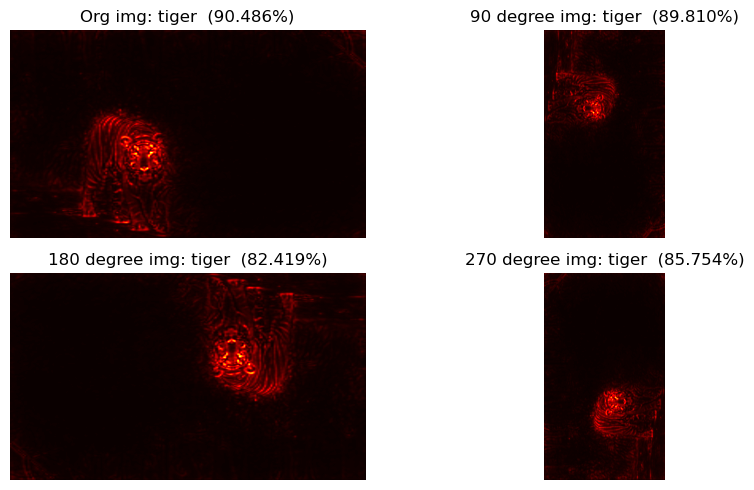

In [24]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# Plot the original image in the first subplot
axes[0,0].imshow(lrp1, cmap='hot')
axes[0,0].set_title(f"Org img: {pred1}  ({100*score1:.3f}%)")
axes[0,0].axis('off')

# Plot the resized LRP heatmap in the second subplot
axes[0,1].imshow(lrp2, cmap='hot')
axes[0,1].set_title(f"90 degree img: {pred2}  ({100*score2:.3f}%)")
axes[0,1].axis('off')

# Plot the resized LRP heatmap in the second subplot
axes[1,0].imshow(lrp3, cmap='hot')
axes[1,0].set_title(f"180 degree img: {pred3}  ({100*score3:.3f}%)")
axes[1,0].axis('off')

# Plot the resized LRP heatmap in the second subplot
axes[1,1].imshow(lrp4, cmap='hot')
axes[1,1].set_title(f"270 degree img: {pred4}  ({100*score4:.3f}%)")
axes[1,1].axis('off')

# Adjust the space between the subplots
plt.tight_layout()

# Show the plots
plt.savefig("LRP_comparison_rotations.png")
plt.show()
